### Imports

In [74]:
!! pip install pymixbox pandas

['Requirement already satisfied: pymixbox in c:\\python310\\lib\\site-packages (2.0.0)',
 'Requirement already satisfied: pandas in c:\\python310\\lib\\site-packages (2.3.3)',
 'Requirement already satisfied: python-dateutil>=2.8.2 in c:\\users\\safii\\appdata\\roaming\\python\\python310\\site-packages (from pandas) (2.9.0.post0)',
 'Requirement already satisfied: tzdata>=2022.7 in c:\\python310\\lib\\site-packages (from pandas) (2025.2)',
 'Requirement already satisfied: pytz>=2020.1 in c:\\python310\\lib\\site-packages (from pandas) (2025.2)',
 'Requirement already satisfied: numpy>=1.22.4 in c:\\python310\\lib\\site-packages (from pandas) (2.2.6)',
 'Requirement already satisfied: six>=1.5 in c:\\users\\safii\\appdata\\roaming\\python\\python310\\site-packages (from python-dateutil>=2.8.2->pandas) (1.17.0)',
 'WARNING: You are using pip version 21.2.3; however, version 25.3 is available.',
 "You should consider upgrading via the 'C:\\Python310\\python.exe -m pip install --upgrade pi

In [75]:
import pandas as pd
import math
from typing import Callable
import mixbox
import math

### Error Definitions

Delta E	Perception

|  Value  | Meaning |
|---------|---|
|  <= 1.0 | Not perceptible by human eyes.  |
|  1 - 2  | Perceptible through close observation.  |
| 2 - 10  | Perceptible at a glance. |
| 11 - 49 | Colors are more similar than opposite  |
| 100     | Colors are exact opposite 

In [76]:
def deltaE76(color1: list[float], color2: list[float]) -> float:
    dl = color1[0] - color2[0]
    da = color1[1] - color2[1]
    db = color1[2] - color2[2]

    return math.sqrt(dl*dl + da*da + db*db)

In [77]:
def rmsErrorForDim(color1: list[float], color2: list[float], dim: str) -> float:
    labDim = 0 if dim == "l" else 1 if dim == "a" else 2
    return math.sqrt((color1[labDim] - color2[labDim])**2)

In [78]:
def calculateAverageError(errorFunction: Callable[[list[float], list[float]], float], dataset, field1: str, field2: str) -> float:
    error_values = []
    for i in range(len(dataset)):
        targetLab = [float(x) for x in dataset[field1][i].split(";")]
        resultLab = [float(x) for x in dataset[field2][i].split(";")]
        error_values.append(errorFunction(targetLab, resultLab))
    return sum(error_values) / len(error_values)

### Color Mixing with Mixbox

In [134]:
def mix_colors_mixbox(weights: list[float], palette: list[tuple[int, int, int]]) -> tuple[int, int, int]:
    """
    ColorMixer Implementation: Realistic pigment mixing using Mixbox library.
    
    Mixbox provides physically-accurate color mixing that simulates real paint behavior,
    including subtractive color mixing effects.
    
    This implementation uses iterative pairwise mixing for multiple colors.
    
    Args:
        weights: List of weights (0.0 to 1.0) for each color in the palette.
        palette: List of RGB colors as tuples (R, G, B) where each component is 0-255.
    
    Returns:
        Mixed RGB color as tuple (R, G, B) where each component is 0-255.
    """
    if len(weights) != len(palette):
        raise ValueError("Weights size must match palette size")
    
    if not palette:
        # Return neutral gray for empty palette
        return (128, 128, 128)
    
    # Create list of colors with their weights, filtering negligible contributions
    weighted_colors = [
        (palette[i], weights[i])
        for i in range(len(weights))
        if weights[i] > 0.01  # Filter negligible contributions
    ]
    
    # Sort by weight descending
    weighted_colors.sort(key=lambda x: x[1], reverse=True)
    
    if not weighted_colors:
        return (128, 128, 128)
    
    if len(weighted_colors) == 1:
        # Single color - return it directly
        return weighted_colors[0][0]
    
    # Iteratively mix colors using Mixbox
    mixed_color = weighted_colors[0][0]
    total_weight = weighted_colors[0][1]
    
    for i in range(1, len(weighted_colors)):
        next_color = weighted_colors[i][0]
        next_weight = weighted_colors[i][1]
        
        # Calculate mixing ratio
        t = next_weight / (total_weight + next_weight)
        
        # Use Mixbox for realistic pigment mixing
        mixed_color = mixbox.lerp(mixed_color, next_color, t)
        total_weight += next_weight
    
    return mixed_color

## Comaring different optimization strategies

In [79]:
def count_false_weights(result_w, target_w, threshold, similarity_groups=None):
    # Simple non-domain logic
    if similarity_groups is None:
        return sum(abs(r - t) > threshold for r, t in zip(result_w, target_w))

    # Domain-aware logic
    COLOR_TO_GROUP = {
        idx: g
        for g, indices in similarity_groups.items()
        for idx in indices
    }

    false_count = 0
    for i, (r, t) in enumerate(zip(result_w, target_w)):
        if abs(r - t) <= threshold:
            continue

        group = COLOR_TO_GROUP[i]
        group_indices = similarity_groups[group]

        target_sum = sum(target_w[j] for j in group_indices)
        result_sum = sum(result_w[j] for j in group_indices)

        if abs(target_sum - result_sum) <= threshold:
            continue

        false_count += 1

    return false_count


In [80]:
import math

def rmse_false_weights(result_w, target_w, threshold, similarity_groups=None):
    if similarity_groups is None:
        diffs = [(r - t)**2 for r, t in zip(result_w, target_w) if abs(r - t) > threshold]
        return math.sqrt(sum(diffs) / len(diffs)) if diffs else 0.0

    COLOR_TO_GROUP = {
        idx: g
        for g, indices in similarity_groups.items()
        for idx in indices
    }

    sq_errors = []

    for i, (r, t) in enumerate(zip(result_w, target_w)):
        diff = r - t
        if abs(diff) <= threshold:
            continue

        group = COLOR_TO_GROUP[i]
        group_indices = similarity_groups[group]

        target_sum = sum(target_w[j] for j in group_indices)
        result_sum = sum(result_w[j] for j in group_indices)

        if abs(target_sum - result_sum) <= threshold:
            continue

        sq_errors.append(diff * diff)

    return math.sqrt(sum(sq_errors) / len(sq_errors)) if sq_errors else 0.0


In [81]:
import os
from pathlib import Path

db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\"

csv_files = [f for f in os.listdir(db_folder) if f.endswith('.csv')]

results = []

for csv_file in csv_files:
    path = os.path.join(db_folder, csv_file)
    dataset = pd.read_csv(path, delimiter=",")
    
    average_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")
    average_error_initial = calculateAverageError(deltaE76, dataset, "targetLab", "initialLab")
    
    mean_num_eval = dataset["numberOfEvaluations"].mean()
    mean_time_ms = dataset["runtimeMs"].mean()

    dataset["resultWeights"] = dataset["resultWeights"].str.split(";").apply(lambda x: list(map(float, x)))
    dataset["targetWeights"] = dataset["targetWeights"].str.split(";").apply(lambda x: list(map(float, x)))

    threshold = 0.1

    dataset["NumFalseWeights"] = dataset.apply(
    lambda row: count_false_weights_domain(row["resultWeights"], row["targetWeights"], 0.1),
    axis=1
    )

    dataset["RMSEFalseWeights"] = dataset.apply(
        lambda row: rmse_false_weights_domain(row["resultWeights"], row["targetWeights"], 0.1),
        axis=1
    )
    
    dataset["converged"] = dataset["converged"].astype(str).str.lower() == "true"
    convergence_rate = dataset["converged"].mean()


    results.append({
        'Optimizer': dataset["optimizerName"][0],
        'Average Result Error': average_error_result,
        'Average Initial Error': average_error_initial,
        'Mean Evaluations': mean_num_eval,
        "Mean Time Ms": mean_time_ms,
        "Num False Weights": dataset["NumFalseWeights"].mean(),
        "RMSE False Weights": dataset["RMSEFalseWeights"].mean(),
        "Convergance Rate": convergence_rate,
    })

results_df = pd.DataFrame(results)
results_df

,Optimizer,Average Result Error,Average Initial Error,Mean Evaluations,Mean Time Ms,Num False Weights,RMSE False Weights,Convergance Rate
0,BOBYQA,43.671001,56.685908,87.0,16.85,9.40,0.307499,1.0
1,CMA-ES,5.164211,56.685908,9410.5,123.60,5.15,0.460372,0.0
2,Nelder-Mead,26.004887,56.685908,194.2,0.10,10.05,2.588688,1.0
3,NSGAII,10.189884,56.685908,50000.0,103965.85,3.40,0.479072,1.0
4,Powell,26.004887,56.685908,194.2,1.25,10.05,2.588688,1.0
5,SMSEMOA,12.941743,56.685908,50000.0,34950.85,4.60,0.528263,1.0


## Comparing different optimization parameters for a given strategy

In [87]:
import os
import pandas as pd

def analyze_optimizer_minimal(common_columns, dataset_folder):

    csv_files = [
        f for f in os.listdir(dataset_folder)
    ]

    results = []

    for csv_file in csv_files:
        path = os.path.join(db_folder, csv_file)
        dataset = pd.read_csv(path)

        # --- Compute errors ---
        avg_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")
        avg_error_initial = calculateAverageError(deltaE76, dataset, "targetLab", "initialLab")

        # --- Common statistics ---
        runtime_mean = dataset["runtimeMs"].mean()
        dataset["converged"] = dataset["converged"].astype(str).str.lower() == "true"
        convergence_rate = dataset["converged"].mean()

        # --- Detect optimizer-specific parameters ---
        param_columns = dataset.columns.difference(common_columns)

        optimizer_params = {
            col: dataset[col].iloc[0] for col in param_columns
        }

        # --- Add results ---
        row = {
            "Average Result Error": avg_error_result,
            "Average Initial Error": avg_error_initial,
            "Runtime (ms)": runtime_mean,
            "Convergance Rate": convergence_rate,
        }

        # Add optimizer-specific parameters
        row.update(optimizer_params)

        results.append(row)

    return pd.DataFrame(results)


In [88]:
import os
import pandas as pd

def analyze_optimizer(
    dataset_folder,
    common_columns,
    threshold=0.1,
    similarity_groups=None,
    weight_result_col="resultWeights",
    weight_target_col="targetWeights"
):

    csv_files = [f for f in os.listdir(dataset_folder) if f.endswith(".csv")]
    results = []

    for csv_file in csv_files:
        path = os.path.join(dataset_folder, csv_file)
        dataset = pd.read_csv(path)

        # --- Parse weights ---
        dataset[weight_result_col] = dataset[weight_result_col].str.split(";").apply(lambda x: list(map(float, x)))
        dataset[weight_target_col] = dataset[weight_target_col].str.split(";").apply(lambda x: list(map(float, x)))

        # --- Compute domain-aware or simple weight errors ---
        dataset["NumFalseWeights"] = dataset.apply(
            lambda row: count_false_weights(
                row[weight_result_col], row[weight_target_col], threshold, similarity_groups
            ),
            axis=1
        )

        dataset["RMSEFalseWeights"] = dataset.apply(
            lambda row: rmse_false_weights(
                row[weight_result_col], row[weight_target_col], threshold, similarity_groups
            ),
            axis=1
        )

        # --- ΔE metrics ---
        avg_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")
        avg_error_initial = calculateAverageError(deltaE76, dataset, "targetLab", "initialLab")

        # --- Convergence ---
        dataset["converged"] = dataset["converged"].astype(str).str.lower() == "true"
        conv_rate = dataset["converged"].mean()

        # --- Common statistics ---
        runtime_mean = dataset["runtimeMs"].mean()

        # --- Detect optimizer-specific parameters automatically ---
        param_columns = dataset.columns.difference(common_columns)
        optimizer_params = {col: dataset[col].iloc[0] for col in param_columns}

        mean_num_eval = dataset["numberOfEvaluations"].mean()

        # --- Assemble row ---
        row = {
            "File": csv_file,
            "Average Result Error": avg_error_result,
            "Average Initial Error": avg_error_initial,
            "Runtime (ms)": runtime_mean,
            "Convergence Rate": conv_rate,
            "Number of Evaluations": mean_num_eval
        }

        row.update(optimizer_params)
        results.append(row)

    return pd.DataFrame(results)


In [113]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\"

SIMILAR_GROUPS = {
    "yellow": [0, 2, 6],
    "red":    [1, 4],
    "blue":   [3, 8, 10],
    "earth":  [5],
    "white":  [7],
    "black":  [9],
}

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

COMPARISON_COLUMNS = [
    'optimizerName',
    'Average Result Error',
    'Average Initial Error',
    'Runtime (ms)',
    'Convergence Rate',
    'NumFalseWeights',
    'RMSEFalseWeights',
    "Number of Evaluations"
]


results = analyze_optimizer(
    dataset_folder=db_folder,
    common_columns=COMMON_COLUMNS,
    threshold=0.1,
    similarity_groups=SIMILAR_GROUPS,
)
results[COMPARISON_COLUMNS]


,optimizerName,Average Result Error,Average Initial Error,Runtime (ms),Convergence Rate,NumFalseWeights,RMSEFalseWeights,Number of Evaluations
0,BOBYQA,43.671001,56.685908,16.85,1.0,11,0.314357,87.0
1,CMA-ES,5.164211,56.685908,123.60,0.0,3,0.570986,9410.5
2,Nelder-Mead,26.004887,56.685908,0.10,1.0,10,3.384677,194.2
3,NSGAII,10.189884,56.685908,103965.85,1.0,3,0.874155,50000.0
4,Powell,26.004887,56.685908,1.25,1.0,10,3.384677,194.2
5,SMSEMOA,12.941743,56.685908,34950.85,1.0,3,0.476050,50000.0


## Performance Overview
- CMA-ES: lowest error for reasonable time considering number of evaluations and lowest weight error rate.
- NSGAII: second lowest error but way too slow, number of evaluations possibly wrong
- SMSEMOA: same as NSGAII
- Nelder-Mead	and Powell: super fast but way less accurate
- BOBYQA: worst by performance

| Optimizer       | Error Rank | Speed Rank | Weight Quality Rank | Convergence Rank | Overall Score |
| --------------- | ---------- | ---------- | ------------------- | ---------------- | ------------- |
| **CMA-ES**      | 🥇 1       | 4          | 1                   | 6                | **12**        |
| **NSGA-II**     | 2          | 6          | 2                   | 1                | **11**        |
| **SMSEMOA**     | 3          | 5          | 3                   | 1                | **12**        |
| **Nelder-Mead** | 4          | 🥇 1       | 5                   | 1                | **11**        |
| **Powell**      | 4          | 2          | 5                   | 1                | **12**        |
| **BOBYQA**      | 6          | 3          | 6                   | 1                | **16**        |


In [ ]:
!! pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt

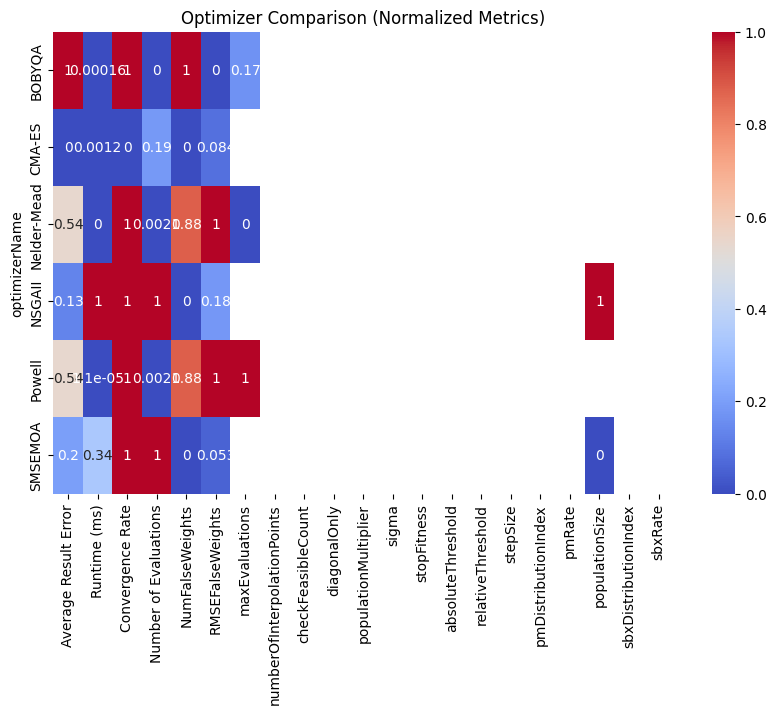

In [125]:
UNUSED_COLUMNS = [
    "Average Initial Error",
]

df = results.drop(UNUSED_COLUMNS, axis=1)

df = df.set_index("optimizerName")

# 2. Select only numeric columns
numeric_df = df.select_dtypes(include="number")

# 3. Normalize numeric columns
df_norm = (numeric_df - numeric_df.min()) / (numeric_df.max() - numeric_df.min())

# 4. Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_norm, annot=True, cmap="coolwarm")
plt.title("Optimizer Comparison (Normalized Metrics)")
plt.show()


## Hyperparameter Optimization for CMA-ES

In [102]:

def find_best_parameters(dir_path: str, common_columns: list[str]):
    results = []

    for file in os.listdir(dir_path):
        if not file.endswith(".csv"):
            continue

        full_path = os.path.join(dir_path, file)
        dataset = pd.read_csv(full_path, sep=",")

        avg_error_result = calculateAverageError(deltaE76, dataset, "targetLab", "resultLab")

        param_columns = dataset.columns.difference(common_columns)
        params = {col: dataset[col].iloc[0] for col in param_columns}

        params["avg_error_result"] = avg_error_result
        params["file"] = file

        results.append(params)

    # Convert list of dicts → DataFrame
    results_df = pd.DataFrame(results)

    # --- Find best parameters ---
    best = results_df.loc[results_df["avg_error_result"].idxmin()]

    return results_df, best

### Nelder Mead (> 22 min)

In [ ]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Hyperparameter-Runs-Nelder-Mead\\"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

find_best_parameters(db_folder, COMMON_COLUMNS)[1]


checkFeasibleCount                         11
diagonalOnly                               11
optimizerName                          CMA-ES
populationMultiplier                       13
sigma                                0.389002
stopFitness                          0.001234
avg_error_result                     3.982888
file                    run-1765058286487.csv
Name: 138, dtype: object

### CMA-ES (> 16)

In [126]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Hyperparameter-Runs-CMA-ES\\"

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

find_best_parameters(db_folder, COMMON_COLUMNS)[1]


checkFeasibleCount                         11
diagonalOnly                               12
optimizerName                          CMA-ES
populationMultiplier                       12
sigma                                0.067537
stopFitness                             0.001
avg_error_result                     2.036092
file                    run-1765061237168.csv
Name: 266, dtype: object

### Overall best parameters for CMA-ES
|  parameter | value  |
|---|---|
| checkFeasibleCount  |  11 |
| diagonalOnly  | 12  |
|  populationMultiplier |  12 |
| sigma  | 0.067537  |
| stopFitness  | 0.001  |
|  avg_error_result | 2.036092  |

In [130]:
db_folder = "C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Optimized\\"

SIMILAR_GROUPS = {
    "yellow": [0, 2, 6],
    "red":    [1, 4],
    "blue":   [3, 8, 10],
    "earth":  [5],
    "white":  [7],
    "black":  [9],
}

COMMON_COLUMNS = [
    "targetLab",
    "resultLab",
    "initialLab",
    "targetWeights",
    "resultWeights",
    "initialWeights",
    "numberOfEvaluations",
    "mixingErrorName",
    "penalties",
    "normalizer",
    "initialGuessType",
    "runtimeMs",
    "converged",
]

COMPARISON_COLUMNS = [
    'optimizerName',
    'Average Result Error',
    'Average Initial Error',
    'Runtime (ms)',
    'Convergence Rate',
    'NumFalseWeights',
    'RMSEFalseWeights',
    "Number of Evaluations"
]


results = analyze_optimizer(
    dataset_folder=db_folder,
    common_columns=COMMON_COLUMNS,
    threshold=0.1,
    similarity_groups=SIMILAR_GROUPS,
)
results[COMPARISON_COLUMNS]


,optimizerName,Average Result Error,Average Initial Error,Runtime (ms),Convergence Rate,NumFalseWeights,RMSEFalseWeights,Number of Evaluations
0,CMA-ES,2.666649,54.065407,129.48,0.0,4,0.418352,9681.96


In [ ]:
!! pip install matplotlib

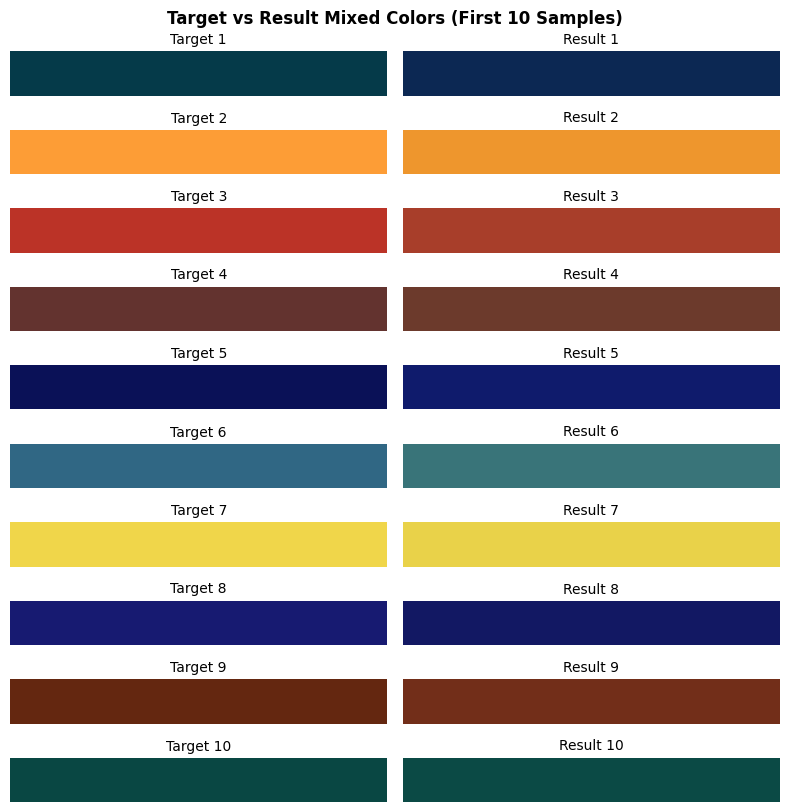

,row,target_hex,result_hex
0,0,#053a49,#0c2853
1,1,#fd9d36,#ee962d
2,2,#bb3327,#a83e2a
3,3,#63332f,#6c3a2c
4,4,#0a1157,#0f1b6c
5,5,#306784,#397479
6,6,#f0d64a,#e9d249
7,7,#171a71,#121863
8,8,#642710,#722e19
9,9,#094743,#0b4a45


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_hex
import json

with open("C:\\Users\\safii\\CI_presentation\\palette.json", "r") as file:
    palette_data = json.load(file)

dataset = pd.read_csv("C:\\Users\\safii\\CI_presentation\\datasets\\CMA-ES-Optimized\\cmaes-results-2.csv")
dataset = dataset[["targetLab", "resultLab", "targetWeights", "resultWeights"]]

# Extract RGB palette from JSON
palette = [tuple(color['rgb']) for color in palette_data]

# Parse weights from dataset
dataset["targetWeights_parsed"] = dataset["targetWeights"].str.split(";").apply(lambda x: [float(w) for w in x])
dataset["resultWeights_parsed"] = dataset["resultWeights"].str.split(";").apply(lambda x: [float(w) for w in x])

# Select 10 random samples
num_samples = 10
random_indices = dataset.sample(n=min(num_samples, len(dataset)), random_state=42).index
results = []

for idx in random_indices:
    target_weights = dataset.loc[idx, "targetWeights_parsed"]
    result_weights = dataset.loc[idx, "resultWeights_parsed"]
    
    # Mix colors using mixbox
    target_color = mix_colors_mixbox(target_weights, palette)
    result_color = mix_colors_mixbox(result_weights, palette)
    
    results.append({
        'row': idx,
        'target_rgb': target_color,
        'result_rgb': result_color,
        'target_hex': '#{:02x}{:02x}{:02x}'.format(*target_color),
        'result_hex': '#{:02x}{:02x}{:02x}'.format(*result_color)
    })

# Create visual table with colored cells
fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 0.8))

for i, result in enumerate(results):
    # Target color
    axes[i, 0].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=result['target_hex']))
    axes[i, 0].set_xlim(0, 1)
    axes[i, 0].set_ylim(0, 1)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Target (Row {result['row']})", fontsize=10)
    
    # Result color
    axes[i, 1].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=result['result_hex']))
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Result (Row {result['row']})", fontsize=10)

plt.tight_layout()
plt.suptitle("Target vs Result Mixed Colors (10 Random Samples)", y=1.01, fontsize=12, fontweight='bold')
plt.show()

# Also show the RGB and hex values
display_df = pd.DataFrame(results)
display_df[['row', 'target_hex', 'result_hex']]